In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random
import pickle
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

## Preprocessing

In [ ]:
chicago1 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2001_to_2004.csv", error_bad_lines=False, low_memory=False)
chicago2 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2005_to_2007.csv", error_bad_lines=False, low_memory=False)
chicago3 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2008_to_2011.csv", error_bad_lines=False, low_memory=False)
chicago4 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2012_to_2017.csv", error_bad_lines=False, low_memory=False)

b'Skipping line 1513591: expected 23 fields, saw 24\n'
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [ ]:
chicago = pd.concat([chicago1, chicago2, chicago3, chicago4], ignore_index = False, axis=0)
chicago.isna().sum()

Unnamed: 0                   0
ID                           0
Case Number                  7
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      1990
Arrest                       0
Domestic                     0
Beat                         0
District                    91
Ward                    700224
Community Area          702091
FBI Code                     0
X Coordinate            105573
Y Coordinate            105573
Year                         0
Updated On                   0
Latitude                105573
Longitude               105574
Location                105574
dtype: int64

In [ ]:
chicago.Date = pd.to_datetime(chicago.Date, format='%m/%d/%Y %I:%M:%S %p')

In [ ]:
chicago = chicago.dropna()
chicago.shape

(7145213, 23)

In [ ]:
#Dropping unwanted columns as they will not give us any useful information
chicago = chicago.drop(['Unnamed: 0'], axis = 1)
chicago = chicago.drop(['ID'], axis = 1)
chicago = chicago.drop(['Case Number'], axis = 1)

In [ ]:
#Converting categories to numerical values
chicago['Block'] = pd.factorize(chicago["Block"])[0]
chicago['IUCR'] = pd.factorize(chicago["IUCR"])[0]
chicago['Description'] = pd.factorize(chicago["Description"])[0]
chicago['Location Description'] = pd.factorize(chicago["Location Description"])[0]
chicago['FBI Code'] = pd.factorize(chicago["FBI Code"])[0]
chicago['Location'] = pd.factorize(chicago["Location"])[0]

In [ ]:
#Grouping less number of type of crime to others from the primary type column
all_cl = chicago.groupby(['Primary Type'])['Block'].size().reset_index()
all_cl['Amt'] = all_cl['Block']
all_cl = all_cl.drop(['Block'], axis=1)
all_cl = all_cl.sort_values(['Amt'], ascending=[False])
unwanted = all_cl.tail(13)

chicago.loc[chicago['Primary Type'].isin(unwanted['Primary Type']), 'Primary Type'] = 'OTHERS'

In [ ]:
Classes = chicago['Primary Type'].unique()
chicago['Primary Type'] = pd.factorize(chicago["Primary Type"])[0] 
chicago['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

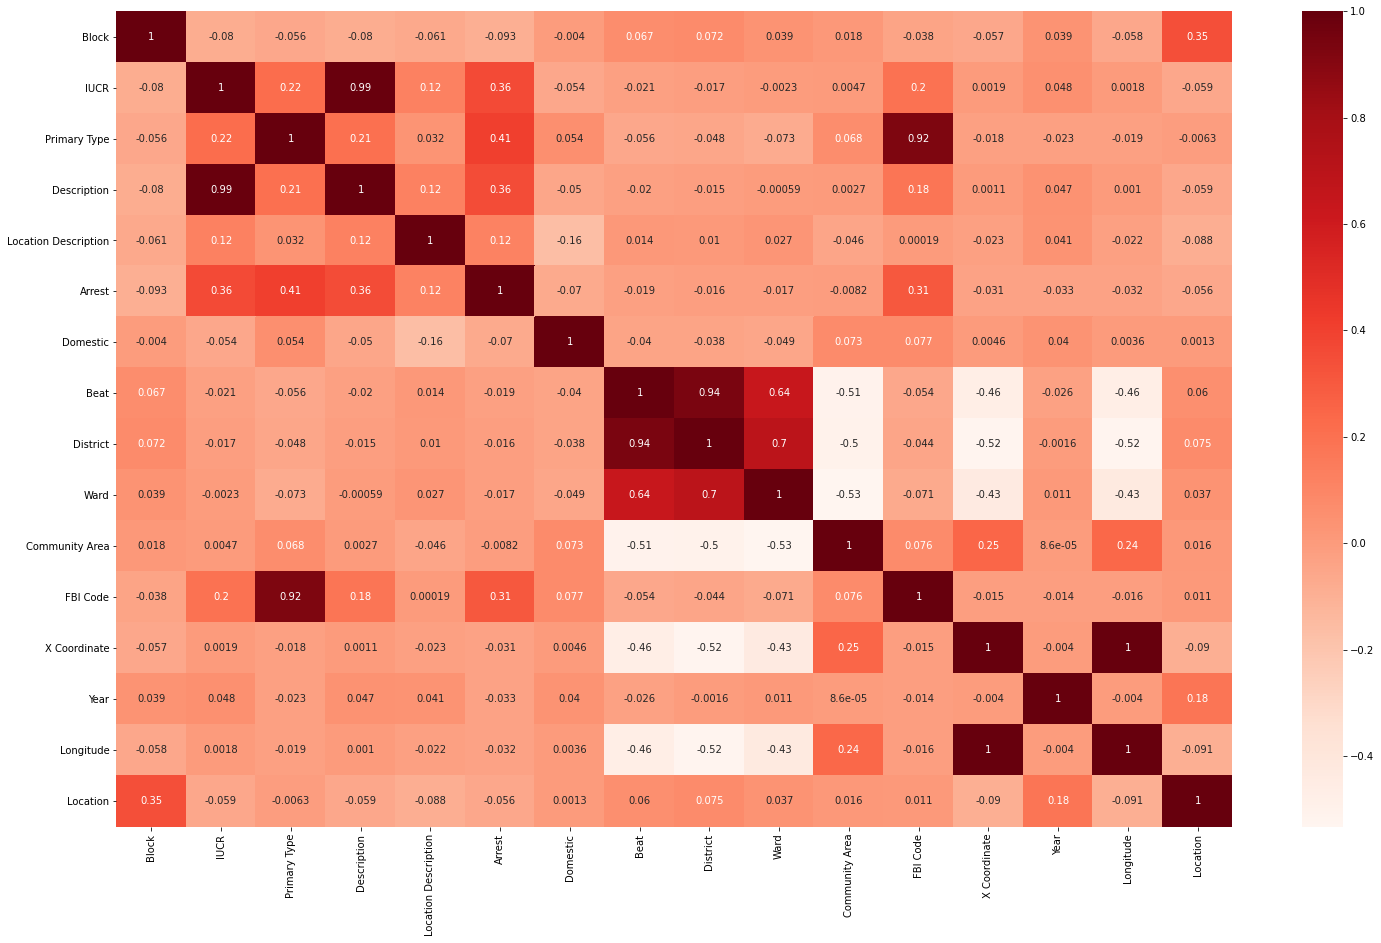

In [ ]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_features = chicago.drop(['Primary Type'], axis=1)
Y = chicago['Primary Type']

#Using Pearson Correlation
plt.figure(figsize=(25,15))
cor = chicago.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig("heat_map.jpeg")
plt.show()

In [ ]:
#selecting the most relevant features

features = abs(cor['Primary Type'])
features = features[features > 0.2]
features

IUCR            0.218894
Primary Type    1.000000
Description     0.209489
Arrest          0.408842
FBI Code        0.923808
Name: Primary Type, dtype: float64

In [ ]:
chicago.head()
features = ['Primary Type','Arrest','FBI Code']
Features = chicago[['Primary Type','Arrest','FBI Code']]

In [ ]:
target = chicago['Primary Type']
Target = ['Primary Type']
target

1           0
4           1
6           2
7           0
9           1
           ..
1456709    11
1456710     7
1456711    11
1456712    11
1456713     0
Name: Primary Type, Length: 7145213, dtype: int64

In [ ]:
pickle.dump(Features, open("Features.p", "wb"))
pickle.dump(target, open("target.p", "wb"))
pickle.dump(features, open("features.p", "wb"))
pickle.dump(Target, open("Target.p", "wb"))

In [ ]:
X = chicago.copy()
X.drop(['Primary Type'], axis=1)

,Date,Block,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,2003-03-01 00:00:00,0,0,0,0,False,True,935,9.0,11.0,61.0,0,1173974.0,1876757.0,2003.0,04/15/2016 08:55:02 AM,41.817229156,-87.637328,0
4,2003-05-01 01:00:00,1,1,1,0,False,False,2233,22.0,34.0,49.0,1,1174948.0,1831051.0,2003.0,04/15/2016 08:55:02 AM,41.691784636,-87.635116,1
6,2001-01-01 11:00:00,2,2,2,0,True,True,531,5.0,9.0,50.0,2,1182247.0,1829375.0,2001.0,08/29/2006 03:46:28 AM,41.687020002,-87.608445,2
7,2003-03-15 00:00:00,3,3,3,1,False,False,2222,22.0,21.0,73.0,0,1169911.0,1844832.0,2003.0,04/15/2016 08:55:02 AM,41.729712374,-87.653159,3
9,2003-01-01 00:00:00,4,4,4,0,False,False,1134,11.0,24.0,29.0,1,1154521.0,1895755.0,2003.0,04/15/2016 08:55:02 AM,41.869772159,-87.708180,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456709,2016-05-03 23:33:00,5846,43,43,2,True,True,1034,10.0,28.0,30.0,12,1159105.0,1.8883e+06,2016.0,05/10/2016 03:56:50 PM,41.8492,-87.691556,82133
1456710,2016-05-03 23:30:00,21042,52,51,2,True,True,731,7.0,17.0,69.0,9,1175230.0,1.85618e+06,2016.0,05/10/2016 03:56:50 PM,41.7607,-87.633335,285712
1456711,2016-05-03 00:15:00,10893,53,20,39,False,False,825,8.0,15.0,66.0,17,1161027.0,1.86281e+06,2016.0,05/10/2016 03:56:50 PM,41.7792,-87.685207,46290
1456712,2016-05-03 21:07:00,1027,43,43,39,False,True,423,4.0,7.0,46.0,12,1197261.0,1.85073e+06,2016.0,05/10/2016 03:56:50 PM,41.7453,-87.552773,13456


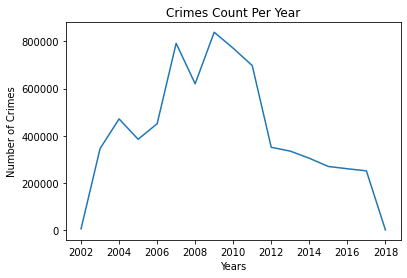

In [ ]:
#Counting crimes number vs year
chicago.index = pd.DatetimeIndex(chicago.Date)
plt.plot(chicago.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')
plt.savefig('Crime_count_yearwise.jpeg')
plt.show()

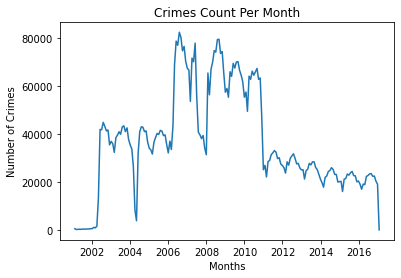

In [ ]:
plt.plot(chicago.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
plt.savefig('Crime_count_monthwise.jpeg')
plt.show()

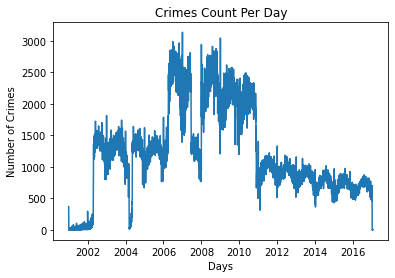

In [ ]:
plt.plot(chicago.resample('D').size())
plt.title('Crimes Count Per Day')
plt.xlabel('Days')
plt.ylabel('Number of Crimes')
plt.savefig('Crime_count_daywise.jpeg')
plt.show()

## Prophet

In [ ]:
chicago_predictions_daywise= chicago.resample('D').size().reset_index()

In [ ]:
chicago_predictions_daywise

,Date,0
0,2001-01-01,369
1,2001-01-02,12
2,2001-01-03,6
3,2001-01-04,0
4,2001-01-05,9
...,...,...
5857,2017-01-14,3
5858,2017-01-15,2
5859,2017-01-16,3
5860,2017-01-17,1


In [ ]:
chicago_predictions_daywise.columns = ['Date', 'Number of Crimes']

In [ ]:
final_prediction = pd.DataFrame(chicago_predictions_daywise)
final_prediction = final_prediction.rename(columns = {'Date':'ds', 'Number of Crimes': 'y'})
prophet = Prophet(changepoint_prior_scale=0.5, seasonality_mode='multiplicative')
prophet.fit(final_prediction)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_prediction = prophet.make_future_dataframe(periods=3650)  #periods = no. of days for prediction
forecast = prophet.predict(future_prediction)

In [ ]:
# %matplotlib inline
# plt.rcParams['figure.figsize'] = 25,20

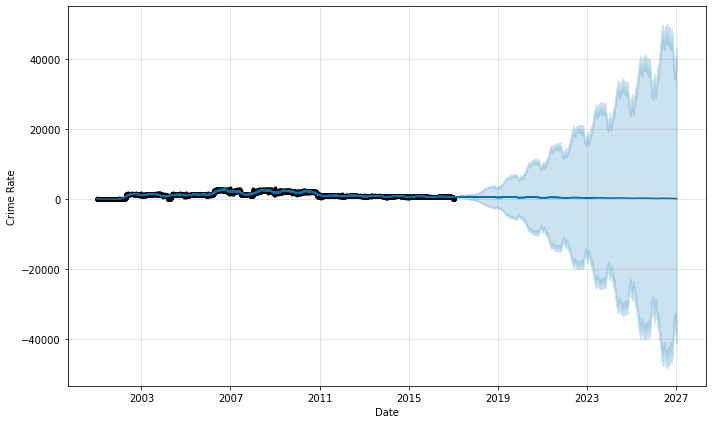

In [ ]:
graph = prophet.plot(forecast, xlabel='Date', ylabel='Crime Rate')
plt.savefig("Prediction for 10 years DayWise.jpeg")

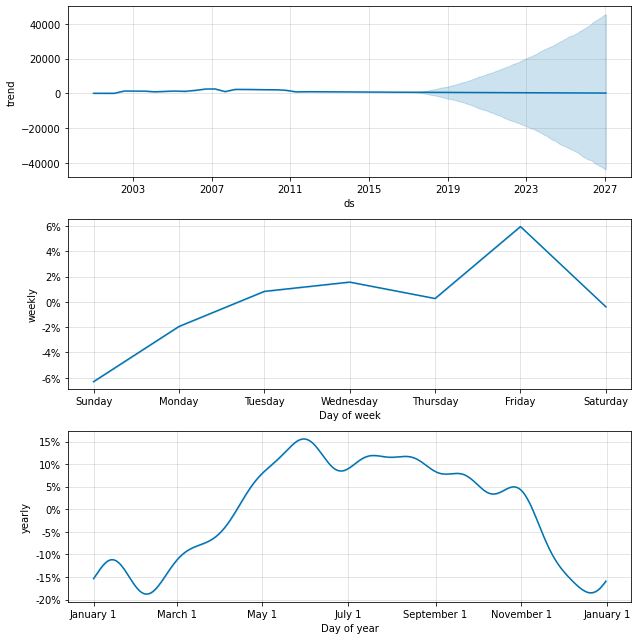

In [ ]:
figure_graph = prophet.plot_components(forecast)
plt.savefig("Prediction for 10 years DayWise_1.jpeg")

In [ ]:
#predicting the crime rate month wise for next 10 years
chicago_predictions_monthwise= chicago.resample('M').size().reset_index()
chicago_predictions_monthwise.columns = ['Date', 'Number of Crimes']
final_prediction_m = pd.DataFrame(chicago_predictions_monthwise)
final_prediction_m = final_prediction_m.rename(columns = {'Date':'ds', 'Number of Crimes': 'y'})
prophet = Prophet(changepoint_prior_scale=0.5, seasonality_mode='multiplicative')
prophet.fit(final_prediction_m)
future_prediction_m = prophet.make_future_dataframe(periods=3650)  #periods = no. of days for prediction
forecast_m = prophet.predict(future_prediction_m)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


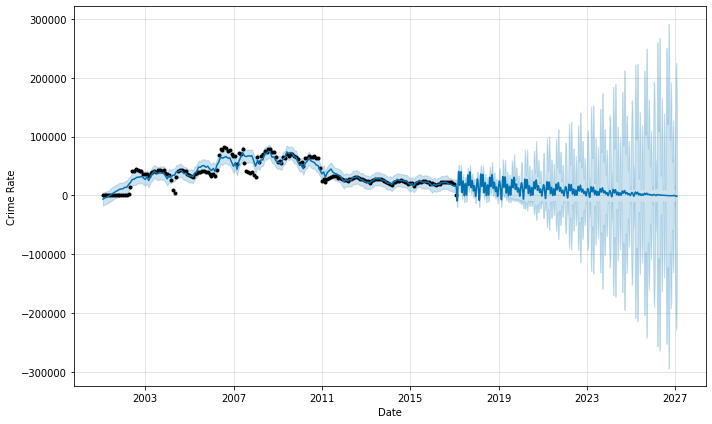

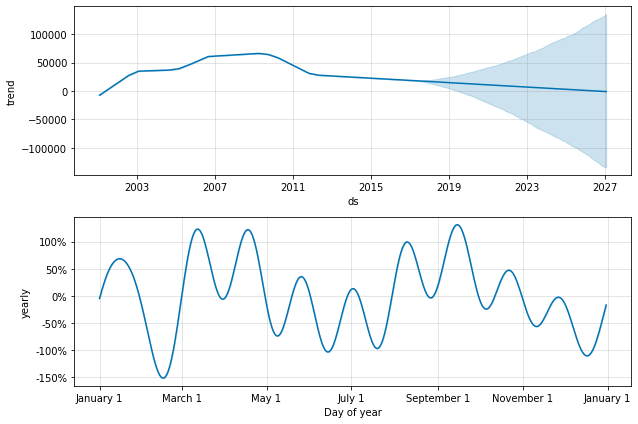

In [ ]:
graph = prophet.plot(forecast_m, xlabel='Date', ylabel='Crime Rate')
plt.savefig("Prediction for 10 years monthwise-1.jpeg")
figure_graph_m = prophet.plot_components(forecast_m)
plt.savefig("Prediction for 10 years monthwise.jpeg")

In [ ]:
cv = cross_validation(prophet, initial='1095 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 25 forecasts with cutoffs between 2004-04-04 00:00:00 and 2016-02-01 00:00:00


In [ ]:
valid_metrics = ['mape']
performance_metrics(cv, metrics = valid_metrics)

,horizon,mape
0,36 days,0.637593
1,38 days,0.623364
2,40 days,0.601677
3,41 days,0.623243
4,43 days,0.624149
...,...,...
194,359 days,0.473103
195,360 days,0.459711
196,361 days,0.492024
197,364 days,0.495948


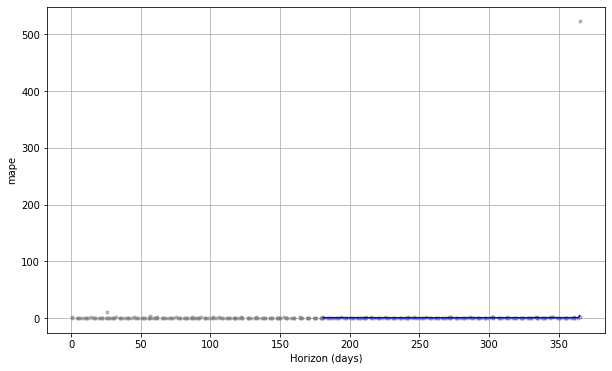

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = (plot_cross_validation_metric(cv, metric='mape', rolling_window = 0.5))

In [ ]:
#predicting the crime rate year wise for next 10 years
chicago_predictions_yearwise= chicago.resample('Y').size().reset_index()
chicago_predictions_yearwise.columns = ['Date', 'Number of Crimes']
final_prediction_y = pd.DataFrame(chicago_predictions_yearwise)
final_prediction_y = final_prediction_y.rename(columns = {'Date':'ds', 'Number of Crimes': 'y'})
prophet = Prophet(changepoint_prior_scale=0.5, seasonality_mode='multiplicative')
prophet.fit(final_prediction_y)
future_prediction_y = prophet.make_future_dataframe(periods=3650)  #periods = no. of days for prediction
forecast_y = prophet.predict(future_prediction_y)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


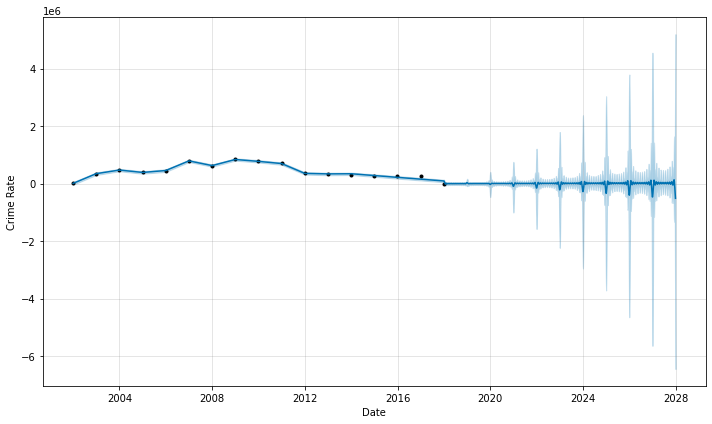

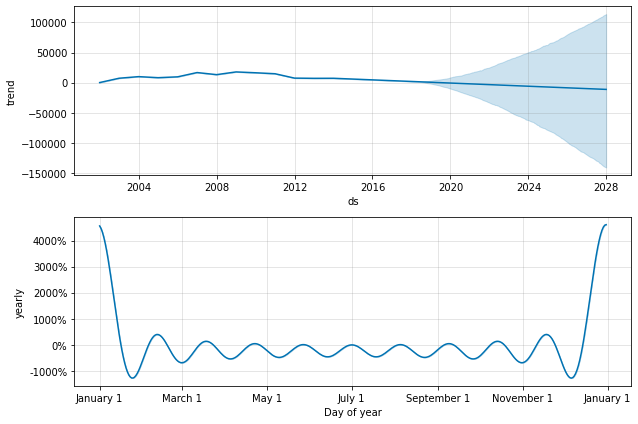

In [ ]:
graph = prophet.plot(forecast_y, xlabel='Date', ylabel='Crime Rate')
plt.savefig("Prediction for 10 years yearhwise_1.jpeg")
figure_graph_y = prophet.plot_components(forecast_y)
plt.savefig("Prediction for 10 years yearWise.jpeg")

## Random Forest Regressor

In [ ]:
chicago_daywise = chicago.resample('D').size().reset_index()
chicago_daywise.columns = ['Date', 'Crimes']

In [ ]:
chicago_daywise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5862 entries, 0 to 5861
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5862 non-null   datetime64[ns]
 1   Crimes  5862 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 91.7 KB


In [ ]:
data = chicago_daywise.set_index(["Date"])

In [ ]:
print(data)

            Crimes
Date              
2001-01-01     369
2001-01-02      12
2001-01-03       6
2001-01-04       0
2001-01-05       9
...            ...
2017-01-14       3
2017-01-15       2
2017-01-16       3
2017-01-17       1
2017-01-18       3

[5862 rows x 1 columns]


In [ ]:
split = pd.Timestamp('2013-01-01')
train = data.loc[:split]
test = data.loc[split:]

In [ ]:
for s in range(1,2):
    train['X-{}'.format(s)] = train['Crimes'].shift(s)
    test['X-{}'.format(s)] = test['Crimes'].shift(s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X_train = train.dropna().drop('Crimes', axis=1)
y_train = train.dropna().drop('X-1', axis=1)

X_test = test.dropna().drop('Crimes', axis=1)
y_test = test.dropna().drop('X-1', axis=1)

print(X_train, y_train)

              X-1
Date             
2001-01-02  369.0
2001-01-03   12.0
2001-01-04    6.0
2001-01-05    0.0
2001-01-06    9.0
...           ...
2012-12-28  681.0
2012-12-29  852.0
2012-12-30  802.0
2012-12-31  705.0
2013-01-01  732.0

[4383 rows x 1 columns]             Crimes
Date              
2001-01-02      12
2001-01-03       6
2001-01-04       0
2001-01-05       9
2001-01-06       9
...            ...
2012-12-28     852
2012-12-29     802
2012-12-30     705
2012-12-31     732
2013-01-01    1159

[4383 rows x 1 columns]


In [ ]:
print(X_test.shape)

(1478, 1)


In [ ]:
X_train = X_train.select_dtypes(include=['float64'])
for col in X_train.columns.values:
  X_train[col] = X_train[col].astype('int64')

In [ ]:
X_test = X_test.select_dtypes(include=['float64'])
for col in X_test.columns.values:
  X_test[col] = X_test[col].astype('int64')

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
pred = model.predict(X_test)

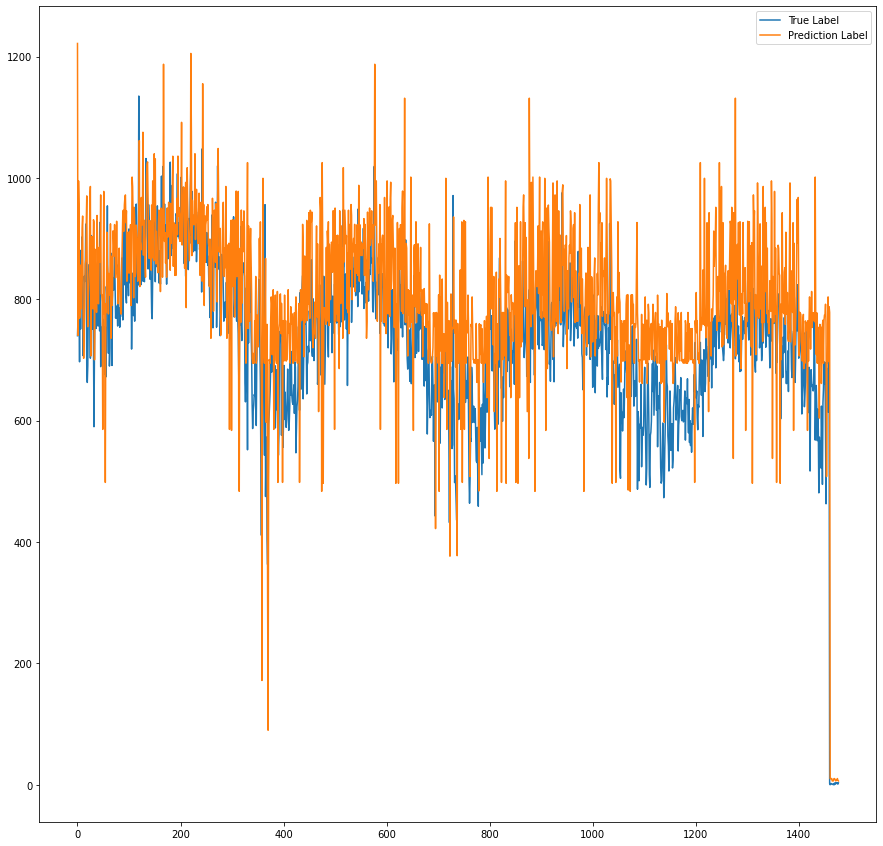

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(y_test,label='True Label')
plt.plot(pred,label='Prediction Label')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [ ]:
# mse = mean_squared_error(y_test, pred, squared = True)
mae = mean_absolute_error(y_test,pred)
r2 = r2_score(y_test, pred)
# print('MSE: %f' % mse)
print('r2: %f' % r2)
print("MAE: %f" % mae)

r2: 0.076048
MAE: 101.228690


## SVM

In [ ]:
chicago_daywise_SVM = chicago.resample('D').size().reset_index()
chicago_daywise_SVM.columns = ['Date', 'Crimes']

In [ ]:
data1 = chicago_daywise_SVM.set_index(["Date"])

In [ ]:
split1 = pd.Timestamp('2014-01-01')
train1 = data.loc[:split1]
test1 = data.loc[split1:]
print(train.shape, test1.shape)

(4384, 2) (1114, 1)


In [ ]:
for s in range(1,2):
    train1['X-{}'.format(s)] = train1['Crimes'].shift(s)
    test1['X-{}'.format(s)] = test1['Crimes'].shift(s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X_train1 = train1.dropna().drop('Crimes', axis=1)
y_train1 = train1.dropna().drop('X-1', axis=1)

X_test1 = test1.dropna().drop('Crimes', axis=1)
y_test1 = test1.dropna().drop('X-1', axis=1)

print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(4748, 1) (4748, 1) (1113, 1) (1113, 1)


In [ ]:
X_train1 = X_train1.select_dtypes(include=['float64'])
for col in X_train1.columns.values:
  X_train1[col] = X_train1[col].astype('int64')

X_test1 = X_test1.select_dtypes(include=['float64'])
for col in X_test1.columns.values:
  X_test1[col] = X_test1[col].astype('int64')

print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(4748, 1) (4748, 1) (1113, 1) (1113, 1)


In [ ]:
print(X_train1, y_train1, X_test1, y_test1)

            X-1
Date           
2001-01-02  369
2001-01-03   12
2001-01-04    6
2001-01-05    0
2001-01-06    9
...         ...
2013-12-28  717
2013-12-29  714
2013-12-30  703
2013-12-31  621
2014-01-01  543

[4748 rows x 1 columns]             Crimes
Date              
2001-01-02      12
2001-01-03       6
2001-01-04       0
2001-01-05       9
2001-01-06       9
...            ...
2013-12-28     714
2013-12-29     703
2013-12-30     621
2013-12-31     543
2014-01-01     956

[4748 rows x 1 columns]             X-1
Date           
2014-01-02  956
2014-01-03  475
2014-01-04  556
2014-01-05  573
2014-01-06  402
...         ...
2017-01-14    3
2017-01-15    3
2017-01-16    2
2017-01-17    3
2017-01-18    1

[1113 rows x 1 columns]             Crimes
Date              
2014-01-02     475
2014-01-03     556
2014-01-04     573
2014-01-05     402
2014-01-06     363
...            ...
2017-01-14       3
2017-01-15       2
2017-01-16       3
2017-01-17       1
2017-01-18       3

[1113 rows x 1

In [ ]:
X_train1 = X_train1.to_numpy()
y_train1 = y_train1.to_numpy()
X_test1 = X_test1.to_numpy()
y_test1 = y_test1.to_numpy()

print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(4748, 1) (4748, 1) (1113, 1) (1113, 1)


In [ ]:
from sklearn import svm

In [ ]:
model1 = svm.LinearSVR()
model1.fit(X_train1,y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [ ]:
pred1 = model1.predict(X_test1)

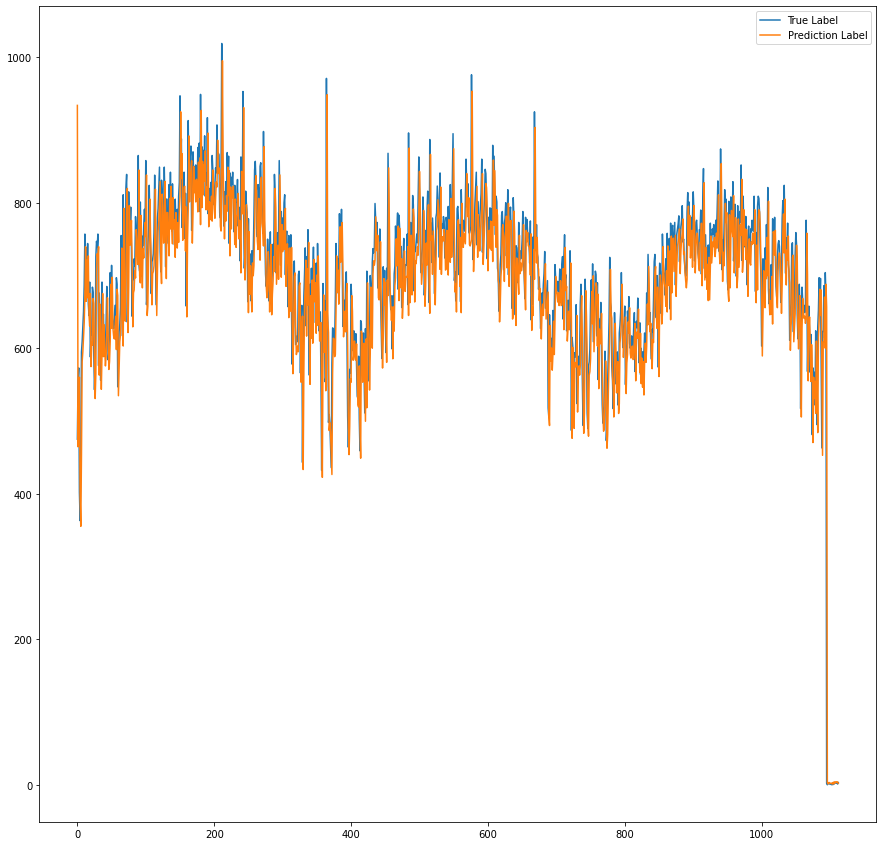

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(y_test1,label='True Label')
plt.plot(pred1,label='Prediction Label')
plt.legend()
plt.show()

In [ ]:
# mse = mean_squared_error(y_test, pred, squared = True)
mae = mean_absolute_error(y_test1,pred1)
r2 = r2_score(y_test1, pred1)
# print('MSE: %f' % mse)
print('r2: %f' % r2)
print("MAE: %f" % mae)

r2: 0.687221
MAE: 52.757249
